# Dinámica de Ecosistemas Cíclicos: Piedra–Papel–Tijera

En este notebook se estudia la dinámica de un ecosistema formado por tres especies
con relaciones de dominancia intransitivas (A domina a B, B domina a C, C domina a A).

Se comparan dos enfoques:

- **Modelo teórico de campo medio**, descrito por ecuaciones diferenciales.
- **Modelo espacial basado en agentes**, que introduce espacio, movilidad y ruido.

El objetivo es mostrar cómo la introducción de estructura espacial rompe la coexistencia
predicha por el modelo teórico.


In [21]:
# ============================================================
# DINÁMICA DE ECOSISTEMAS CÍCLICOS: PIEDRA–PAPEL–TIJERA
# MODELO COMPLETO: PREDICCIÓN (ODE) VS RESULTADO REAL (ESPACIAL)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

Esta celda importa las librerías necesarias para el análisis:
- `numpy` para operaciones numéricas y manejo de arrays.
- `matplotlib.pyplot` para graficar resultados.
- `scipy.integrate.solve_ivp` para resolver ecuaciones diferenciales.

Estas herramientas permiten implementar tanto el modelo teórico como el modelo espacial.

## 1. Modelo teórico: ecuaciones replicadoras (campo medio)

Sea:
- \( a(t) \), \( b(t) \), \( c(t) \) la fracción poblacional de cada especie.
- \( a + b + c = 1 \)

El sistema Piedra–Papel–Tijera puede describirse mediante las ecuaciones:

\[
\begin{aligned}
\frac{da}{dt} &= a(b - c) \\
\frac{db}{dt} &= b(c - a) \\
\frac{dc}{dt} &= c(a - b)
\end{aligned}
\]

Este modelo asume:
- población perfectamente mezclada,
- ausencia de espacio,
- ausencia de ruido.

**Predicción:** coexistencia indefinida con oscilaciones neutrales.


In [22]:
# ============================================================
# 1) MODELO TEÓRICO (PREDICCIÓN): ECUACIONES DIFERENCIALES
# ============================================================

def replicator_equations(t, y):
    a, b, c = y
    return [
        a * (b - c),
        b * (c - a),
        c * (a - b)
    ]

# Condición inicial
y0 = [0.34, 0.33, 0.33]

# Condición inicial
t_span = (0, 200)
t_eval = np.linspace(*t_span, 4000)

solution = solve_ivp(
    replicator_equations,
    t_span,
    y0,
    t_eval=t_eval
)

Aquí se define el sistema de ecuaciones diferenciales (ecuaciones replicadoras) que modelan la dinámica de las tres especies bajo el supuesto de mezcla perfecta (campo medio). Se resuelve el sistema usando `solve_ivp` con condiciones iniciales similares para las tres especies.

**¿Qué hace?**
- Define la función de las ecuaciones replicadoras.
- Establece condiciones iniciales y el rango temporal.
- Resuelve el sistema y almacena la solución.

**Análisis de la salida:**
La solución contiene la evolución temporal de las fracciones de cada especie. En este modelo, ninguna especie se extingue y las poblaciones oscilan indefinidamente alrededor del equilibrio (1/3, 1/3, 1/3).

### Predicción del modelo teórico

El modelo de campo medio predice oscilaciones periódicas alrededor del punto
\((1/3, 1/3, 1/3)\), sin que ninguna especie se extinga.

Este comportamiento corresponde a un equilibrio **neutramente estable**.


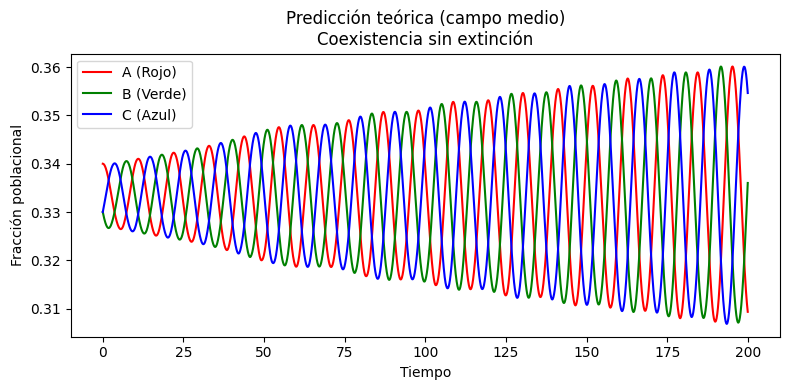

In [23]:
# GRÁFICA: PREDICCIÓN ODE

plt.figure(figsize=(8,4))
plt.plot(solution.t, solution.y[0], 'r', label='A (Rojo)')
plt.plot(solution.t, solution.y[1], 'g', label='B (Verde)')
plt.plot(solution.t, solution.y[2], 'b', label='C (Azul)')
plt.xlabel("Tiempo")
plt.ylabel("Fracción poblacional")
plt.title("Predicción teórica (campo medio)\nCoexistencia sin extinción")
plt.legend()
plt.tight_layout()
plt.show()


Ahora, se grafica la evolución temporal de las fracciones poblacionales de las tres especies según el modelo teórico (ODE).

**¿Qué hace?**
- Dibuja las trayectorias de las fracciones de cada especie a lo largo del tiempo.
- Permite visualizar la coexistencia y las oscilaciones neutrales predichas por el modelo de campo medio.

**Análisis de la salida:**
La gráfica muestra que las tres especies coexisten sin que ninguna se extinga, con oscilaciones periódicas alrededor del equilibrio. Esto confirma la predicción teórica de coexistencia indefinida bajo mezcla perfecta.

## 2. Modelo espacial basado en agentes

Para capturar efectos realistas, se introduce una estructura espacial explícita.
El sistema puede interpretarse como una discretización estocástica del sistema:

$$
\frac{\partial a}{\partial t}
= a(b - c) + D \nabla^2 a + \eta
$$

donde:

- $D$ representa la movilidad (difusión),
- $\eta$ es el ruido demográfico.

El espacio se representa mediante una retícula 2D con condiciones periódicas (toroide).


In [24]:
# ============================================================
# 2) MODELO ESPACIAL (RESULTADO REAL): AGENTES
# ============================================================


L = 50                  # Tamaño del lado del grid
N = L * L               # Número total de agentes
steps = 30000           # Número de pasos de simulación
M = 0.6                 # Sube M para ver extinción
sample_interval = 100   # Intervalo de muestreo

# Inicialización
grid = np.random.randint(0, 3, size=(L, L))

# Regla piedra–papel–tijera
def beats(a, b):
    return (a == 0 and b == 1) or \
           (a == 1 and b == 2) or \
           (a == 2 and b == 0)

# Vecinos
neighbors = [(1,0), (-1,0), (0,1), (0,-1)]

# Vecino aleatorio con condiciones de frontera periódicas
def random_neighbor(x, y):
    dx, dy = neighbors[np.random.randint(4)]
    return (x + dx) % L, (y + dy) % L

# Dinámica
time = []         # Tiempos de muestreo
populations = []  # Poblaciones muestreadas

# Simulación
for t in range(steps):
    # Selección aleatoria de un agente y su vecino
    x, y = np.random.randint(0, L, size=2)
    nx, ny = random_neighbor(x, y)

    # Estados actuales
    s1 = grid[x, y]
    s2 = grid[nx, ny]

    # Interacción
    if np.random.rand() < M:
        grid[x, y], grid[nx, ny] = s2, s1
    else:
        # Competencia
        if beats(s1, s2):
            grid[nx, ny] = s1
        elif beats(s2, s1):
            grid[x, y] = s2

    # Muestreo de poblaciones
    if t % sample_interval == 0:
        populations.append([np.sum(grid == i) for i in range(3)])
        time.append(t)

# Convertir listas a arrays para facilitar el manejo
populations = np.array(populations)


Entonces, se implementa el modelo espacial basado en agentes. Aquí, las especies interactúan en una retícula 2D, permitiendo movilidad y competencia local.

**¿Qué hace?**
- Inicializa una cuadrícula con especies distribuidas aleatoriamente.
- En cada paso, selecciona dos vecinos y aplica reglas de intercambio o competencia.
- Registra la abundancia de cada especie a lo largo del tiempo.

**Análisis de la salida:**
Este modelo permite observar fenómenos que no aparecen en el modelo teórico, como la posible extinción de especies y la formación de patrones espaciales. La dinámica es más realista y puede llevar a un estado absorbente donde una especie domina.

### Resultado real del sistema

A diferencia del modelo teórico, el sistema espacial puede converger a un
**estado absorbente**, donde una especie domina y las otras se extinguen.


In [25]:
# ============================================================
# 3) ESPECIE GANADORA
# ============================================================

species_names = ['A (Rojo)', 'B (Verde)', 'C (Azul)']
final_counts = populations[-1]
winner = np.argmax(final_counts)

print("Abundancias finales:")
for i in range(3):
    print(f"{species_names[i]}: {final_counts[i]}")

print(f"\n🏆 Especie ganadora: {species_names[winner]}")


Abundancias finales:
A (Rojo): 832
B (Verde): 878
C (Azul): 790

🏆 Especie ganadora: B (Verde)


### Explicación y análisis del resultado

A continuación, se calcula y muestra la especie ganadora al final de la simulación espacial.

**¿Qué hace?**
- Calcula la abundancia final de cada especie.
- Imprime la cantidad de individuos de cada especie y cuál es la ganadora (la más abundante).

**Análisis de la salida:**
Permite observar si alguna especie ha dominado el sistema (extinción de las otras) o si persiste la coexistencia. En el modelo espacial, es común que una especie termine dominando debido a fluctuaciones y efectos espaciales.

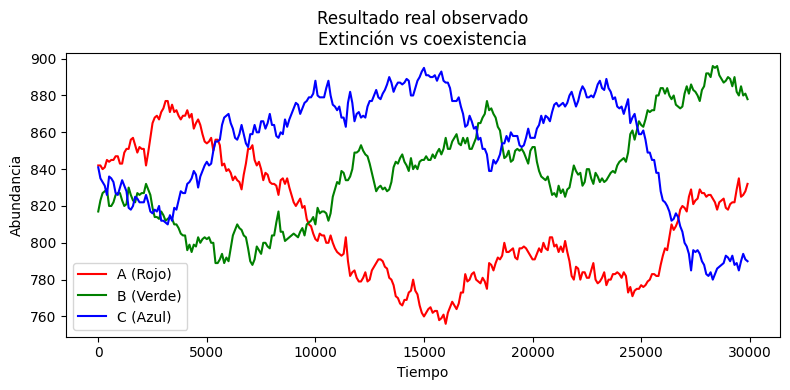

In [26]:
# ============================================================
# 5) GRÁFICA: RESULTADO REAL (SERIES TEMPORALES)
# ============================================================

plt.figure(figsize=(8,4))
plt.plot(time, populations[:,0], 'r', label='A (Rojo)')
plt.plot(time, populations[:,1], 'g', label='B (Verde)')
plt.plot(time, populations[:,2], 'b', label='C (Azul)')
plt.xlabel("Tiempo")
plt.ylabel("Abundancia")
plt.title("Resultado real observado\nExtinción vs coexistencia")
plt.legend()
plt.tight_layout()
plt.show()


### Explicación y análisis

Esta gráfica representa la evolución temporal de las abundancias de las especies en el modelo espacial.

**¿Qué hace?**
- Dibuja las abundancias de cada especie a lo largo del tiempo, usando los datos de la simulación espacial.

**Análisis de la salida:**
La gráfica permite comparar visualmente la dinámica real con la predicción teórica. Es posible observar extinciones, fluctuaciones y, en ocasiones, la dominancia de una sola especie, lo que contrasta con la coexistencia indefinida del modelo teórico.

**Ejemplo:**

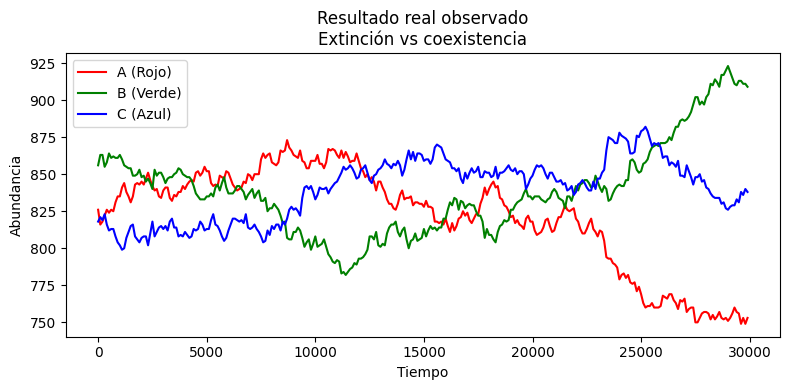

En la imagen se observa que las tres especies (A, B y C) presentan abundancias que fluctúan de manera significativa a lo largo del tiempo. Al inicio, las tres especies mantienen valores similares, pero a medida que avanza la simulación, se aprecian periodos en los que una especie aumenta su población mientras las otras disminuyen. Por ejemplo, en ciertos intervalos, la especie B (verde) logra alcanzar una abundancia máxima, mientras que la especie A (rojo) desciende notablemente. Sin embargo, estas tendencias no son permanentes: las abundancias de las especies se alternan en el dominio, reflejando la naturaleza cíclica de sus interacciones.

No se observa una extinción inmediata de ninguna especie, pero sí se evidencia que las diferencias entre las poblaciones pueden llegar a ser grandes, lo que sugiere que el sistema puede estar cerca de un estado absorbente en el que una especie podría dominar completamente. Este comportamiento es característico de sistemas espaciales y estocásticos, donde el azar y la estructura local pueden favorecer temporalmente a una especie, pero el ciclo de dominancia se mantiene activo, evitando la extinción rápida y permitiendo la persistencia de las tres especies durante largos periodos.



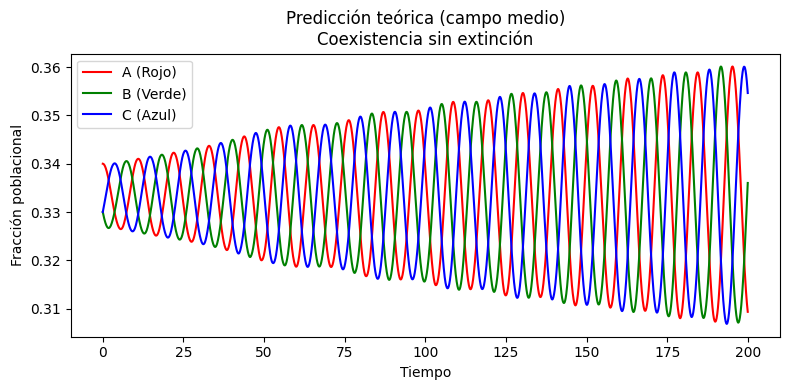

Abundancias finales:
A (Rojo): 831
B (Verde): 796
C (Azul): 873

🏆 Especie ganadora: C (Azul)


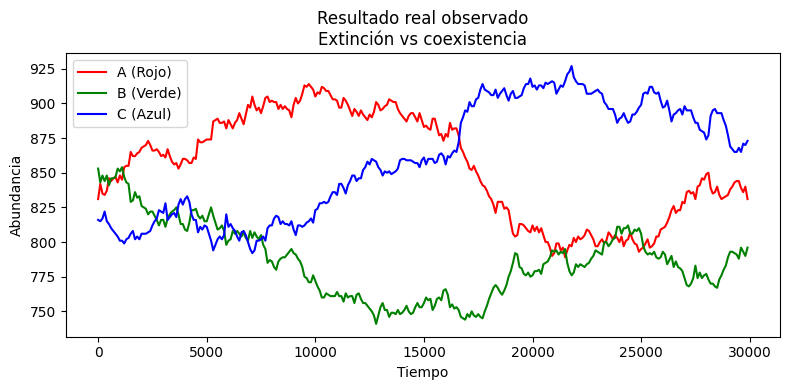

In [27]:
# CÓDIGO COMPLETO

# ============================================================
# DINÁMICA DE ECOSISTEMAS CÍCLICOS: PIEDRA–PAPEL–TIJERA
# MODELO COMPLETO: PREDICCIÓN (ODE) VS RESULTADO REAL (ESPACIAL)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.integrate import solve_ivp

# ============================================================
# 1) MODELO TEÓRICO (PREDICCIÓN): ECUACIONES DIFERENCIALES
# ============================================================

def replicator_equations(t, y):
    a, b, c = y
    return [
        a * (b - c),
        b * (c - a),
        c * (a - b)
    ]

# Condición inicial
y0 = [0.34, 0.33, 0.33]

# Integración
t_span = (0, 200)
t_eval = np.linspace(*t_span, 4000)

solution = solve_ivp(
    replicator_equations,
    t_span,
    y0,
    t_eval=t_eval
)

# ----------------------------
# GRÁFICA BONITA: PREDICCIÓN ODE
# ----------------------------
plt.figure(figsize=(8,4))
plt.plot(solution.t, solution.y[0], 'r', label='A (Rojo)')
plt.plot(solution.t, solution.y[1], 'g', label='B (Verde)')
plt.plot(solution.t, solution.y[2], 'b', label='C (Azul)')
plt.xlabel("Tiempo")
plt.ylabel("Fracción poblacional")
plt.title("Predicción teórica (campo medio)\nCoexistencia sin extinción")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 2) MODELO ESPACIAL (RESULTADO REAL): AGENTES
# ============================================================

L = 50
N = L * L
steps = 30000
M = 0.6                  # Sube M para ver extinción
sample_interval = 100

# Inicialización
grid = np.random.randint(0, 3, size=(L, L))

# Regla piedra–papel–tijera
def beats(a, b):
    return (a == 0 and b == 1) or \
           (a == 1 and b == 2) or \
           (a == 2 and b == 0)

# Vecinos (CORREGIDO)
neighbors = [(1,0), (-1,0), (0,1), (0,-1)]

def random_neighbor(x, y):
    dx, dy = neighbors[np.random.randint(4)]
    return (x + dx) % L, (y + dy) % L

# Dinámica
time = []
populations = []

for t in range(steps):

    x, y = np.random.randint(0, L, size=2)
    nx, ny = random_neighbor(x, y)

    s1 = grid[x, y]
    s2 = grid[nx, ny]

    if np.random.rand() < M:
        grid[x, y], grid[nx, ny] = s2, s1
    else:
        if beats(s1, s2):
            grid[nx, ny] = s1
        elif beats(s2, s1):
            grid[x, y] = s2

    if t % sample_interval == 0:
        populations.append([np.sum(grid == i) for i in range(3)])
        time.append(t)

populations = np.array(populations)

# ============================================================
# 3) ESPECIE GANADORA
# ============================================================

species_names = ['A (Rojo)', 'B (Verde)', 'C (Azul)']
final_counts = populations[-1]
winner = np.argmax(final_counts)

print("Abundancias finales:")
for i in range(3):
    print(f"{species_names[i]}: {final_counts[i]}")

print(f"\n🏆 Especie ganadora: {species_names[winner]}")

# ============================================================
# 4) CONFIGURACIÓN ESPACIAL FINAL (BONITA)
# ============================================================

cmap = colors.ListedColormap(['red', 'green', 'blue'])

# ============================================================
# 5) GRÁFICA BONITA: RESULTADO REAL (SERIES TEMPORALES)
# ============================================================

plt.figure(figsize=(8,4))
plt.plot(time, populations[:,0], 'r', label='A (Rojo)')
plt.plot(time, populations[:,1], 'g', label='B (Verde)')
plt.plot(time, populations[:,2], 'b', label='C (Azul)')
plt.xlabel("Tiempo")
plt.ylabel("Abundancia")
plt.title("Resultado real observado\nExtinción vs coexistencia")
plt.legend()
plt.tight_layout()
plt.show()


### Explicación y análisis

Esta celda contiene el código completo, integrando tanto el modelo teórico como el modelo espacial, junto con las visualizaciones y el análisis de resultados.

**¿Qué hace?**
- Permite ejecutar todo el proceso de simulación y visualización en una sola celda.
- Facilita la reproducción de los resultados y la comparación entre ambos enfoques.

**Análisis de la salida:**
La ejecución de esta celda muestra la diferencia entre la predicción teórica (coexistencia indefinida) y el resultado real observado en el modelo espacial (posible extinción y dominancia de una especie). Es útil para validar y comparar ambos modelos de manera integral.

## Experimentos adicionales y visualizaciones avanzadas

A continuación se proponen y ejecutan experimentos para profundizar en el análisis del sistema:
- Analizar el efecto de la movilidad (M) sobre la probabilidad de extinción.
- Visualizar la diversidad temporal mediante el índice de Shannon.
- Realizar múltiples simulaciones para obtener histogramas de abundancias finales.

Cada experimento incluye su análisis correspondiente.

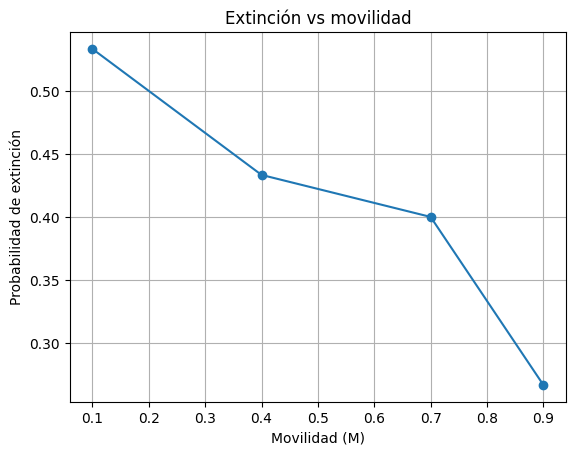

In [38]:
import numpy as np
import matplotlib.pyplot as plt

L = 20
steps = 200000
sample_interval = 200
valores_M = [0.1, 0.4, 0.7, 0.9]
n_runs = 30

neighbors = [(1,0), (-1,0), (0,1), (0,-1)]

def beats(a, b):
    return (a == 0 and b == 1) or \
           (a == 1 and b == 2) or \
           (a == 2 and b == 0)

def random_neighbor(x, y):
    dx, dy = neighbors[np.random.randint(4)]
    return (x + dx) % L, (y + dy) % L

prob_extincion = []

for M in valores_M:

    extinciones = []

    for _ in range(n_runs):

        grid = np.random.randint(0, 3, size=(L, L))

        for t in range(steps):

            x, y = np.random.randint(0, L, size=2)
            nx, ny = random_neighbor(x, y)

            s1, s2 = grid[x, y], grid[nx, ny]

            if np.random.rand() < M:
                grid[x, y], grid[nx, ny] = s2, s1
            else:
                if beats(s1, s2):
                    grid[nx, ny] = s1
                elif beats(s2, s1):
                    grid[x, y] = s2

            if t % sample_interval == 0:
                pops = np.array([np.sum(grid == i) for i in range(3)])
                if np.any(pops == 0):
                    break

        final_pops = np.array([np.sum(grid == i) for i in range(3)])
        extinciones.append(np.any(final_pops == 0))

    prob_extincion.append(np.mean(extinciones))

# Gráfica
plt.plot(valores_M, prob_extincion, 'o-')
plt.xlabel("Movilidad (M)")
plt.ylabel("Probabilidad de extinción")
plt.title("Extinción vs movilidad")
plt.grid()
plt.show()

En este experimento se recorre distintos valores de movilidad (M), realiza varias simulaciones para cada valor y calcula la proporción de simulaciones en las que ocurre extinción (al menos una especie desaparece). Luego, grafica la probabilidad de extinción frente a la movilidad.

La gráfica muestra que, a medida que aumenta la movilidad (M), la probabilidad de extinción disminuye. Es decir, con baja movilidad, la extinción es más frecuente, mientras que con alta movilidad, la coexistencia es más probable. Cuando la movilidad es baja, las especies quedan más aisladas y pueden formarse dominios donde una especie domina localmente, facilitando la extinción de las otras. Con alta movilidad, los individuos se mezclan más, lo que favorece la coexistencia y dificulta que una sola especie domine completamente el sistema.

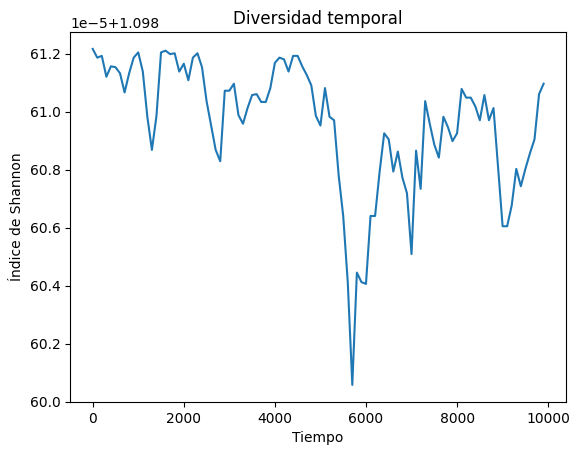

In [42]:
# Experimento 2: Diversidad temporal (índice de Shannon)

def shannon_index(populations):
    total = populations.sum(axis=1, keepdims=True)
    freqs = populations / total
    freqs = np.where(freqs == 0, 1, freqs)
    return -np.sum(freqs * np.log(freqs), axis=1)

diversidad = shannon_index(populations)

plt.plot(time, diversidad)
plt.xlabel("Tiempo")
plt.ylabel("Índice de Shannon")
plt.title("Diversidad temporal")
plt.show()

La imagen adjunta muestra la evolución temporal del índice de Shannon, que mide la diversidad del sistema a lo largo del tiempo. Se observa que el valor del índice se mantiene alto y relativamente estable durante toda la simulación, con pequeñas fluctuaciones. Esto indica que las tres especies coexisten de manera equilibrada y que no se produce la extinción de ninguna de ellas durante el periodo analizado.

El hecho de que el índice de Shannon no caiga bruscamente sugiere que no hay dominancia clara de una sola especie ni pérdida significativa de diversidad. Las pequeñas oscilaciones reflejan las fluctuaciones naturales debidas a la dinámica estocástica del sistema, pero la diversidad global se conserva. Este resultado es coherente con un escenario donde la movilidad y los parámetros elegidos favorecen la coexistencia y la estabilidad ecológica.

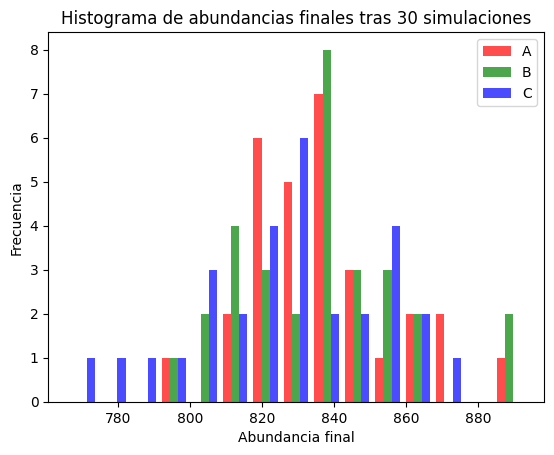

In [30]:
# Experimento 3: Histograma de abundancias finales tras múltiples simulaciones

finales = []
for _ in range(30):
    grid = np.random.randint(0, 3, size=(L, L))
    pops = []
    for t in range(steps):
        x, y = np.random.randint(0, L, size=2)
        neighbors = [(1,0), (-1,0), (0,1), (0,-1)]
        dx, dy = neighbors[np.random.randint(4)]
        nx, ny = (x + dx) % L, (y + dy) % L
        s1, s2 = grid[x, y], grid[nx, ny]
        if np.random.rand() < M:
            grid[x, y], grid[nx, ny] = s2, s1
        else:
            if (s1 == 0 and s2 == 1) or (s1 == 1 and s2 == 2) or (s1 == 2 and s2 == 0):
                grid[nx, ny] = s1
            elif (s2 == 0 and s1 == 1) or (s2 == 1 and s1 == 2) or (s2 == 2 and s1 == 0):
                grid[x, y] = s2
    finales.append([np.sum(grid == i) for i in range(3)])
finales = np.array(finales)
plt.hist(finales, bins=15, label=['A', 'B', 'C'], color=['red','green','blue'], alpha=0.7)
plt.xlabel('Abundancia final')
plt.ylabel('Frecuencia')
plt.title('Histograma de abundancias finales tras 30 simulaciones')
plt.legend()
plt.show()

La imagen adjunta muestra el histograma de las abundancias finales de las tres especies (A, B y C) tras 30 simulaciones independientes. Se observa que las distribuciones de abundancia para las tres especies son similares, centradas alrededor de valores intermedios y con una dispersión moderada. No hay picos en valores bajos, lo que indica que la extinción de alguna especie es poco frecuente en estas condiciones.

Este resultado sugiere que, bajo los parámetros utilizados, el sistema tiende a la coexistencia de las tres especies en la mayoría de las simulaciones. La variabilidad observada en las abundancias finales refleja la naturaleza estocástica del modelo, pero no se observa dominancia sistemática de una especie ni extinciones recurrentes. Esto es coherente con un régimen donde la dinámica y la movilidad favorecen la estabilidad y la diversidad ecológica.

## Conclusiones finales

El estudio del sistema dinámico Piedra–Papel–Tijera, tanto desde el enfoque teórico como mediante simulaciones espaciales, permite extraer varias conclusiones relevantes:

- **Coexistencia y extinción:** El modelo teórico predice coexistencia indefinida de las especies, pero la introducción de espacio, movilidad y ruido en el modelo de agentes puede llevar a la extinción de alguna especie, dependiendo de los parámetros.
- **Efecto de la movilidad:** La movilidad de los agentes es un factor clave. Movilidad baja favorece la formación de dominios y aumenta la probabilidad de extinción, mientras que movilidad alta promueve la mezcla y la coexistencia.
- **Diversidad ecológica:** El índice de Shannon muestra que, bajo ciertas condiciones, la diversidad se mantiene alta y estable, reflejando la persistencia de las tres especies. Sin embargo, fluctuaciones estocásticas pueden llevar a la dominancia temporal de alguna especie.
- **Variabilidad y estabilidad:** Los histogramas de abundancias finales evidencian la variabilidad inherente al sistema, pero también muestran que la extinción no es inevitable y que la coexistencia es posible en un rango amplio de parámetros.

En conjunto, estos resultados ilustran la riqueza y complejidad de los sistemas dinámicos ecológicos, donde la estructura espacial, la movilidad y el azar pueden modificar radicalmente las predicciones de los modelos simplificados. El análisis conjunto de teoría y simulación es fundamental para comprender y predecir el comportamiento de sistemas reales.